In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging

logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

61306/61306 [==============================] - 1s 11us/step


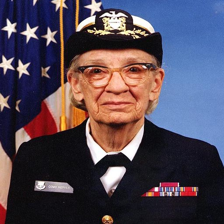

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg',
                                       'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 0s 430ms/step


(1, 1001)

In [8]:
result[0]

array([ 0.19967622,  1.067894  , -0.09610031, ...,  0.10602819,
       -0.56032056, -0.07089152], dtype=float32)

In [11]:
predicted_class = np.argmax(result[0])
predicted_class

653

10484/10484 [==============================] - 0s 20us/step


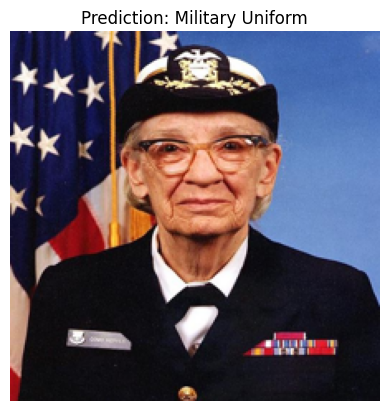

In [12]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt',
                                      'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [15]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_labels = info.features['label'].num_classes

In [20]:
for i, example_image in enumerate(train_examples.take(3)):
    print("Image {} Shape: {}".format(i + 1, example_image[0].shape))

Image 1 Shape: (262, 350, 3)
Image 2 Shape: (409, 336, 3)
Image 3 Shape: (493, 500, 3)


In [21]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES)) / 255.0
    return image, label


BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [22]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 0s 367ms/step


array(['Rottweiler', 'Great Pyrenees', 'Eskimo dog', 'Siamese cat',
       'Labrador retriever', 'Gordon setter', 'giant schnauzer',
       'whippet', 'Tibetan mastiff', 'dishwasher', 'Cardigan', 'tabby',
       'Labrador retriever', 'Egyptian cat', 'redbone', 'Siamese cat',
       'Egyptian cat', 'Norwegian elkhound', 'Egyptian cat', 'tiger cat',
       'golden retriever', 'beagle', 'tiger cat',
       'American Staffordshire terrier', 'Rhodesian ridgeback',
       'black-and-tan coonhound', 'miniature schnauzer', 'papillon',
       'golden retriever', 'Persian cat', 'malinois', 'Egyptian cat'],
      dtype='<U30')

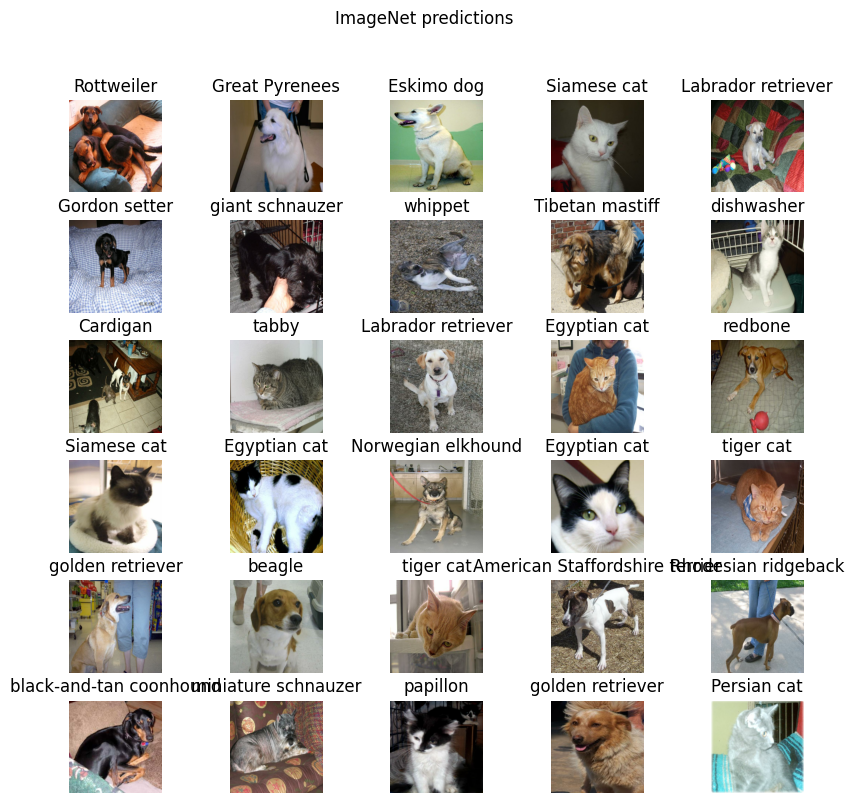

In [23]:
plt.figure(figsize=(10, 9))
for n in range(30):
    plt.subplot(6, 5, n + 1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
    _ = plt.suptitle("ImageNet predictions")

In [25]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [26]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [27]:
feature_extractor.trainable = False

In [28]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 263s 445ms/step - loss: 0.0559 - accuracy: 0.9808 - val_loss: 0.0350 - val_accuracy: 0.9880
Epoch 2/6
582/582 [==============================] - 256s 439ms/step - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.0296 - val_accuracy: 0.9899
Epoch 3/6
582/582 [==============================] - 242s 415ms/step - loss: 0.0256 - accuracy: 0.9914 - val_loss: 0.0382 - val_accuracy: 0.9871
Epoch 4/6
582/582 [==============================] - 267s 458ms/step - loss: 0.0215 - accuracy: 0.9929 - val_loss: 0.0306 - val_accuracy: 0.9903
Epoch 5/6
582/582 [==============================] - 264s 452ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0311 - val_accuracy: 0.9901
Epoch 6/6
582/582 [==============================] - 267s 458ms/step - loss: 0.0173 - accuracy: 0.9949 - val_loss: 0.0310 - val_accuracy: 0.9901


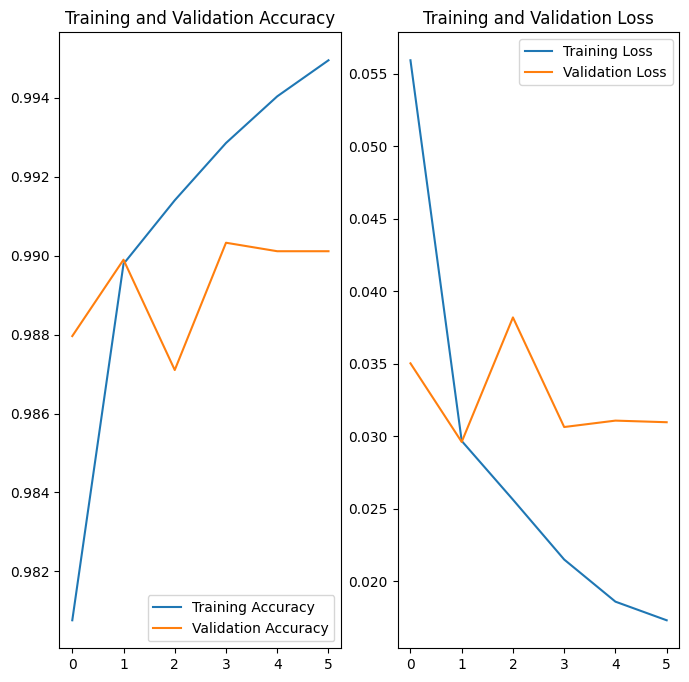

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [32]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [33]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 1s 663ms/step


array(['dog', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog',
       'cat', 'dog', 'cat', 'dog', 'cat', 'dog', 'cat', 'cat', 'dog',
       'cat', 'cat', 'dog', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'cat', 'dog', 'cat', 'dog', 'cat'], dtype='<U3')

In [34]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 1 0]
Predicted labels:  [1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0]


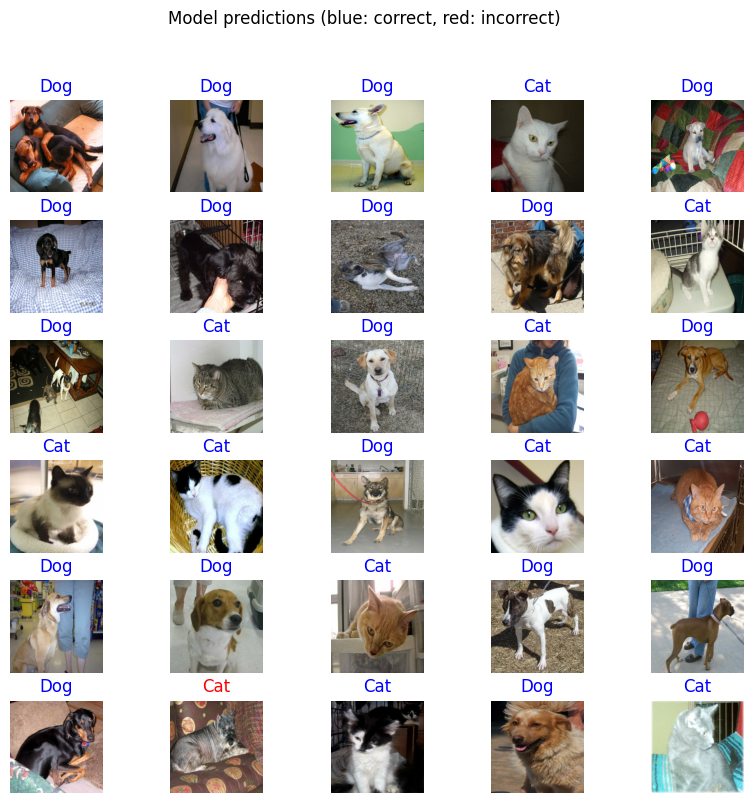

In [35]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")